In [10]:
import numpy as np
import random


In [11]:
import torch.nn


class ContextBandit:
    def __init__(self,arms= 10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()

    # number of states = number of arms. each row represents a state and column an arm
    def init_distribution(self, arms):
        self.bandit_matrix = np.random.rand(arms, arms)

    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.arms)

    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])

    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [15]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)

In [16]:
print(state)

5


In [17]:
print(reward)

10


In [18]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms
# N = batch size
# D_in = input dimension
# H = hidden dimension
# D_out = output dimension

In [19]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU()
)

In [20]:
loss_fn = torch.nn.MSELoss()

In [21]:
env = ContextBandit(arms)

In [22]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [23]:
def softmax(av, tau=1.12):
    softm = np.exp(av/tau) / np.sum(np.exp(av/tau))
    return softm

In [25]:
def train(env, epochs = 5000, learning_rate = 1e-2):
    cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    rewards = []

    for i in range(epochs):
        y_pred = model(cur_state)
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        av_softmax /= av_softmax.sum() # normalizing distributions to make sure it sums to 1

        choice = np.random.choice(arms,p=av_softmax) # choose new action probabilistically
        cur_reward = env.choose_arm(choice) # take action and receive reward

        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward # update one_hot_reward arary to use as labeled trainig data

        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)

        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        cur_state = torch.Tensor(one_hot(arms, env.get_state())) # update current env state
    return np.array(rewards)

In [30]:
new_rewards = train(env)

In [33]:
print(new_rewards)

[ 7 10  6 ...  6 10  8]


In [31]:
import matplotlib.pyplot as plt

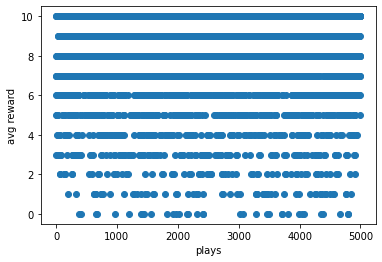

In [32]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("plays")
ax.set_ylabel("avg reward")

ax.scatter(np.arange(len(new_rewards)), new_rewards)